In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

## User input

In [2]:
sample_prefix = 'E:\\Ashlee\\PacBio\\181207\\30s_43N43\\m181207_211324_42131_c000468682559900001500000112312060_s1_p0'
blank_prefix = 'E:\\Ashlee\\PacBio\\181207\\blank\\m181207_203634_42131_c000468672559900001500000112312090_s1_p0'

## Load data

In [3]:
# Load sample data
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break
        
# Load blank grid data

trc_filename_blank = blank_prefix + '.trc.h5'
trc_file_blank = h5py.File(trc_filename_blank, 'r')

# Load data in trace file
dset_blank = trc_file_blank['TraceData']
raw_traces_blank = dset_blank['Traces']
decode_blank = dset_blank['Codec']['Decode']
n_frames = raw_traces.shape[2]
decode_array_blank = np.array(decode_blank)

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

## Decode trace intensities

In [4]:
traces = np.zeros(raw_traces.shape, dtype=np.float16)
for i in range(n_traces):
    traces[i] = decode_array[raw_traces[i]]
    
traces_blank = np.zeros(raw_traces_blank.shape, dtype=np.float16)
for i in range(n_traces):
    traces_blank[i] = decode_array_blank[raw_traces_blank[i]]

## Plot intensity distributions

In [6]:
avg_intens_raw = np.mean(traces, axis=2)
avg_intens_blank = np.mean(traces_blank, axis=2)

avg_intens = avg_intens_raw - avg_intens_blank

E:\Ashlee\Program_Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


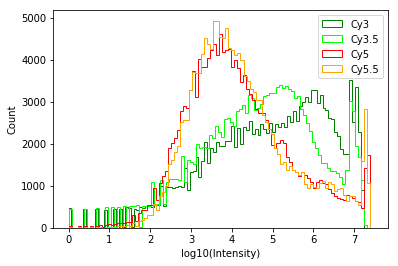

In [10]:
for i in range(4):
    avg_intens_i = np.log(avg_intens.T[i] + 1e-6)
    min_i = 0
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])

plt.xlabel('log10(Intensity)')
plt.ylabel('Count')
plt.legend(lasers)

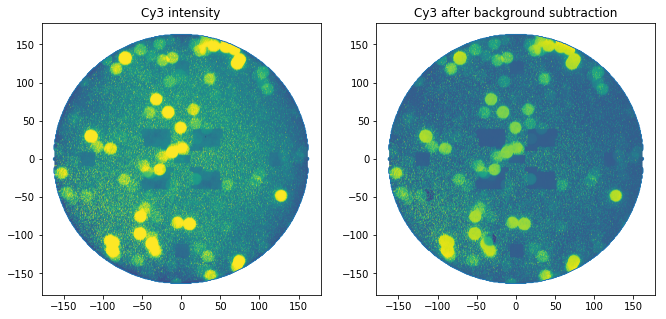

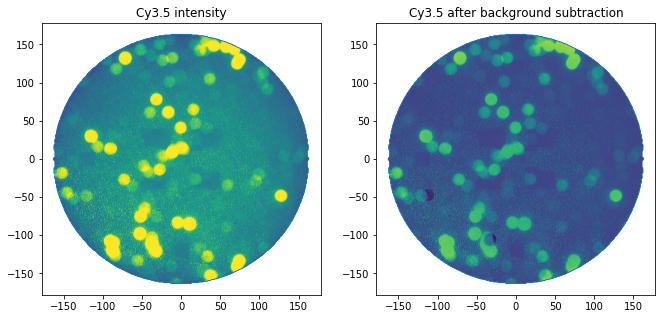

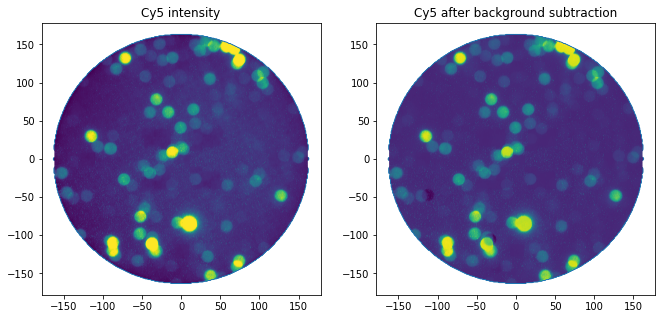

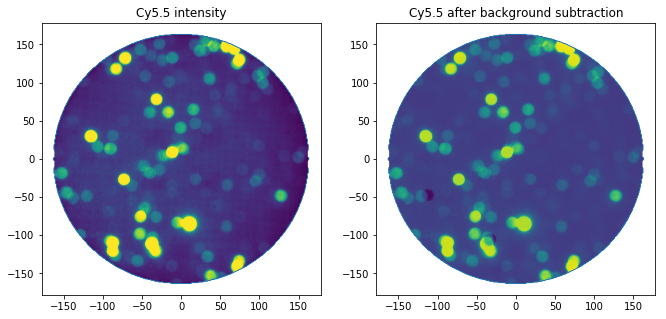

In [16]:
for i in range(4):
    plt.figure(figsize=(11, 5))
    plt.subplot(121)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens_raw.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.subplot(122)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' after background subtraction')
    plt.show()

## Plot variance distributions

In [ ]:
var = np.log10(np.var(traces, axis=2) + 1e-6)

In [ ]:
for i in range(4):
    var_i = var.T[i]
    min_i = 0
    max_i = max(var_i)
    plt.hist(var_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('log10(Variance)')
plt.ylabel('Count')
plt.legend(lasers)

In [ ]:
# Plot variance over the grid

# for i in range(4):
#     plt.figure()
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, var.T[i])
#     plt.title('log10(Variance) of ' + lasers[i])
#     plt.show()

## View a trace

In [ ]:
#i = 112542 # is a good example
i = np.random.randint(0, n_traces)
trace = traces[i]

for i in range(4):
    plt.plot(time_axis, trace[i], color=colors[i])
    i += 1 

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

## Plot average intensity over time for each color

In [ ]:
avg_trace = np.zeros((4, 200))
for i in range(4):
    avg_trace[i] = np.mean(traces[:][:][i], axis=0)

In [ ]:
for i in range(4):
    plt.plot(time_axis, avg_trace[i], color=colors[i])

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

## Background subtraction

## Leakage and $\gamma$ factor corrections